<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/database.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">SingleStore ワークショップ</h1>
    </div>
</div>

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p>このノートブックは無料のスターターワークスペースで実行できます。</p>
    </div>
</div>

この Jupyter ノートブックは、SingleStore のマルチモデル機能の包括的な概要とハンズオンを提供し、単一のデータベース プラットフォーム内でさまざまなデータ タイプを効率的に管理およびクエリする方法を紹介します。

このノートブックは、シンプルな「入門」の例から始まり、様々な標準SQLクエリを使ってデータベースを操作する方法を紹介します。さらに、SQLクエリを分析する方法をいくつか確認します。

その後、機械学習のためのベクター、非構造化データの全文検索、階層型データのためのJSON、位置情報に基づくクエリのための地理空間データ、そして時系列分析のための時系列データなど、様々なデータモデルの追加とクエリ方法を段階的に実演します。

また、StageへのSQL結果の出力と、SingleStore Pipelineを使用してStageからデータを取り込む方法を確認します。

この実践的なアプローチにより、ユーザーはSingleStoreの汎用性と強力なマルチモデル機能を手軽に体験できます。

# 目次
- [はじめに](#はじめに)
- [さまざまな標準SQLクエリ](#さまざまな標準SQLクエリ)
- [クエリの分析コマンド](#クエリの分析コマンド)
- [マルチモデルのデータ操作](#マルチモデルのデータ操作)
    - [ベクトルの追加](##ベクトルの追加)
    - [全文の追加](##全文の追加)
    - [JSONの追加](##JSONの追加)
    - [地理空間情報の追加](##地理空間情報の追加)
    - [時系列の追加](##時系列の追加)
    - [（オプション）地図の作成](##（オプション）地図の作成)
- [Stageの活用](#Stageの活用)
    - [StageへのSQL結果のエクスポート](##StageへのSQL結果のエクスポート)
    - [Stageからのデータ取り込み](##Stageからのデータ取り込み)
- [Shard Keyとデータスキュー](#Shard-Keyとデータスキュー)
- [環境の削除](#環境の削除)
- [まとめ](#まとめ)
- [時間が余った方は・・・](#時間が余った方は・・・)

# はじめに

<p>このノートブックの上部にある<b>ドロップダウンメニュー</b>から、使用するワークスペースとデータベースを選択します（無料のスターターワークスペースは<b>SHARED TIER</b>になります）。</p>
<img src=attachment:4a26e5fa-8cef-47f3-9e11-b795986ef726.png width=50%>
無料のスターターワークスペースを未作成の場合は、左側のナビゲーションメニューから <b>+ Create New</b> を選択して作成してください。
また、既存のスタンダードワークスペースをこのノートブックで使用することもできます。

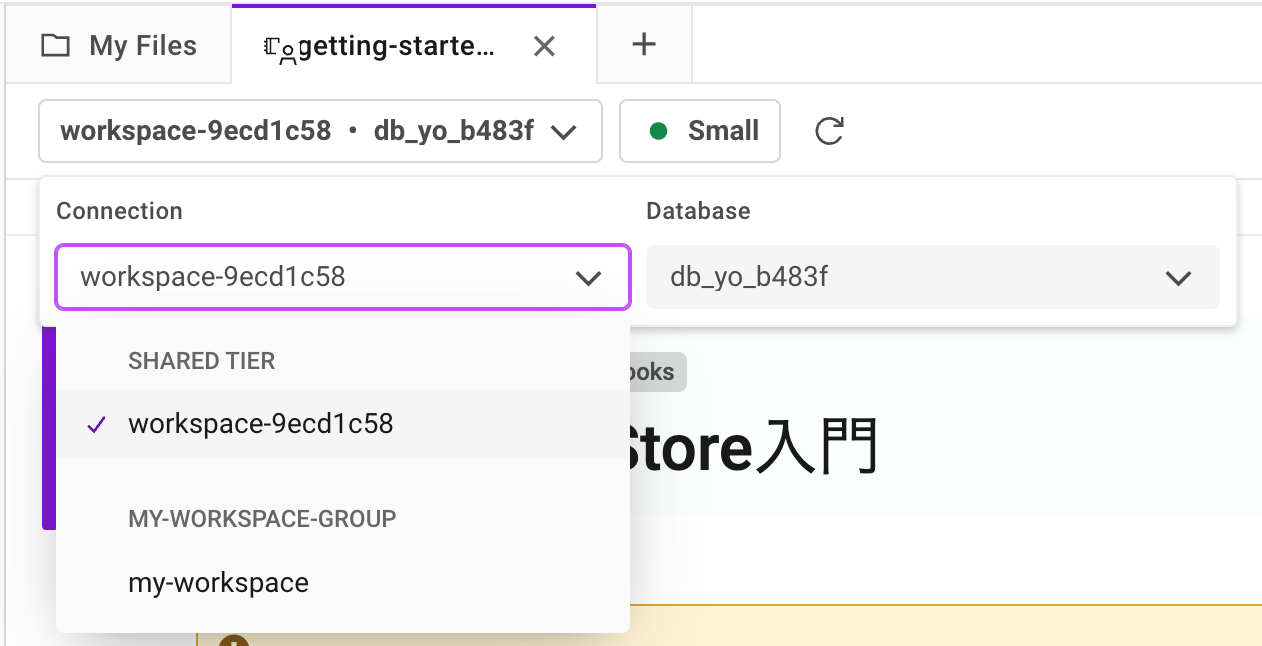

次のコードは、現在のデータベース環境が「Shared Tier（共有ティア）」を使用しているかどうかを確認し、その結果に基づいてデータベースを削除および作成します。

In [6]:
shared_tier_check = %sql SHOW VARIABLES LIKE "is_shared_tier"
if not shared_tier_check or shared_tier_check[0][1] == "OFF":
    %sql DROP DATABASE IF EXISTS multi_model;
    %sql CREATE DATABASE IF NOT EXISTS multi_model;

1 rows affected.

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p>Shared Tierのスターターワークスペースでは、ワークスペース作成時にデフォルトで作成されるデータベースを使用します。追加のデータベースを作成することはできません。</p>
    </div>
</div>

ハンズオンを進めていてわからないことがあれば、各コード欄の右上の<b>Ask SQrL</b>をクリックしてチャットボットのSQrL（スクワーレル）に質問してみましょう。「日本語で」とお願いすると日本語で回答してくれます。

<img src=attachment:a47d28c7-f2b6-4462-9a20-f016f99f96e3.png width=20%><img src=attachment:a8f41d0e-6310-4f9f-bbd8-d3089639f806.png>
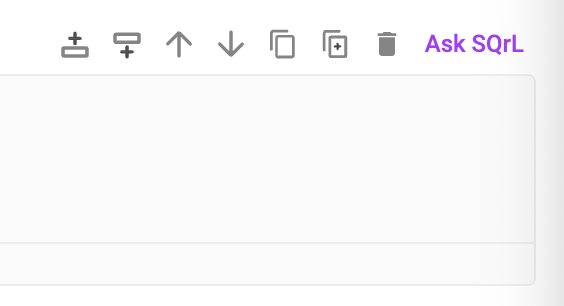
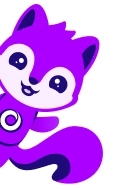

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p>Mac OS環境でSQrLに日本語で入力すると、かな変換時のエンターで入力が送信されてしまいます。かな変換時には<b>Shift + Enter</b>を使用してください（本社側に修正を依頼済みです）。</p>
    </div>
</div>

# さまざまな標準SQLクエリ

## 簡単なテーブルを作成する

この設定により、顧客情報とそれに対応する注文を保存するための基本的なリレーショナル構造が確立されます。
コード欄の左側にある紫色の実行ボタンをクリックしてSQLを実行します。

In [6]:
%%sql
DROP TABLE IF EXISTS customers;
DROP TABLE IF EXISTS orders;

CREATE TABLE IF NOT EXISTS customers /* Creating table for sample data. */(
    customer_id INT PRIMARY KEY,
    customer_name VARCHAR(50),
    country VARCHAR(50)
);

CREATE TABLE IF NOT EXISTS orders /* Creating table for sample data. */(
    order_id INT PRIMARY KEY,
    customer_id INT,
    amount DECIMAL(10, 2),
    product VARCHAR(50)
);

++
||
++
++

## データを挿入する

In [7]:
%%sql
INSERT INTO customers (customer_id, customer_name, country) VALUES
(1, "John Doe", "Canada"),
(2, "Jane Smith", "Canada"),
(3, "Sam Brown", "Canada"),
(4, "Lisa White", "Canada"),
(5, "Mark Black", "Canada");

INSERT INTO orders (order_id, customer_id, amount, product) VALUES
(101, 1, 150.00, "Book"),
(102, 2, 200.00, "Pen"),
(103, 3, 50.00, "Notebook"),
(104, 1, 300.00, "Laptop"),
(105, 4, 250.00, "Tablet");

5 rows affected.

5 rows affected.

++
||
++
++

## テーブルを確認する

顧客テーブルの確認

In [8]:
%%sql
SELECT * from customers;

5 rows affected.

customer_id,customer_name,country
3,Sam Brown,Canada
1,John Doe,Canada
5,Mark Black,Canada
2,Jane Smith,Canada
4,Lisa White,Canada


注文テーブルの確認

In [9]:
%%sql
SELECT * from orders;

5 rows affected.

order_id,customer_id,amount,product
104,1,300.00,Laptop
105,4,250.00,Tablet
101,1,150.00,Book
103,3,50.00,Notebook
102,2,200.00,Pen


## 金額の合計

In [9]:
%%sql
SELECT
    SUM(amount) AS total_sales
FROM
    orders;

1 rows affected.

total_sales
950.00


## 最低金額

In [10]:
%%sql
SELECT
    MIN(amount) AS min_order_amount
FROM
    orders;

1 rows affected.

min_order_amount
50.00


## 最大金額

In [11]:
%%sql
SELECT
    MAX(amount) AS max_order_amount
FROM
    orders;

1 rows affected.

max_order_amount
300.00


## 平均額

In [12]:
%%sql
SELECT
    ROUND(AVG(amount), 2) AS avg_order_amount
FROM
    orders;

1 rows affected.

avg_order_amount
190.00


## 注文数を数える

In [13]:
%%sql
SELECT
    COUNT(*) AS number_of_orders
FROM
    orders;

1 rows affected.

number_of_orders
5


## 顧客テーブルと注文テーブルを結合する

In [10]:
%%sql
SELECT
    customers.customer_name,
    orders.order_id,
    orders.amount
FROM
    customers, orders
WHERE
    customers.customer_id = orders.customer_id
ORDER BY
    amount ASC;

5 rows affected.

customer_name,order_id,amount
Sam Brown,103,50.00
John Doe,101,150.00
Jane Smith,102,200.00
Lisa White,105,250.00
John Doe,104,300.00


## 顧客ごとにグループ化して合計金額を計算する

In [19]:
%%sql
SELECT
    customers.customer_name,
    SUM(orders.amount) AS total_spent
FROM
    customers, orders
WHERE
    customers.customer_id = orders.customer_id
GROUP BY
    customers.customer_name
ORDER BY
    total_spent DESC;

4 rows affected.

customer_name,total_spent
John Doe,450.00
Lisa White,250.00
Jane Smith,200.00
Sam Brown,50.00


# クエリの分析コマンド

## EXPLAINでクエリを分析する

In [20]:
%%sql
EXPLAIN SELECT
    customers.customer_name,
    SUM(orders.amount) AS total_spent
FROM
    customers, orders
WHERE
    customers.customer_id = orders.customer_id
GROUP BY
    customers.customer_name
ORDER BY
    total_spent DESC;

19 rows affected.

EXPLAIN
WARNING: Histograms have not been collected on the following columns. Consider running the following commands to collect them now:
ANALYZE TABLE db_yo_b483f.`customers` COLUMNS `customer_id` ENABLE;
ANALYZE TABLE db_yo_b483f.`orders` COLUMNS `customer_id` ENABLE;
""
See https://docs.memsql.com/docs/analyze for more information on statistics collection.
""
"Project [customers.customer_name, total_spent] est_rows:5"
Sort [SUM(orders.amount) DESC]
HashGroupBy [SUM(orders.amount) AS total_spent] groups:[customers.customer_name]
HashJoin


## PROFILEでクエリを分析する

In [21]:
%%sql
PROFILE SELECT
    customers.customer_name,
    SUM(orders.amount) AS total_spent
FROM
    customers, orders
WHERE
    customers.customer_id = orders.customer_id
GROUP BY
    customers.customer_name
ORDER BY
    total_spent DESC;

SHOW PROFILE;

4 rows affected.

14 rows affected.

PROFILE
"Project [customers.customer_name, total_spent] est_rows:5 actual_rows: 4 exec_time: 0ms start_time: 00:00:00.043 network_traffic: 0.068000 KB network_time: 0ms"
"Sort [SUM(orders.amount) DESC] actual_rows: 4 exec_time: 0ms start_time: 00:00:00.043 memory_usage: 1,440.384033 KB"
HashGroupBy [SUM(orders.amount) AS total_spent] groups:[customers.customer_name] actual_rows: 4 exec_time: 0ms start_time: 00:00:00.043 memory_usage: 131.072006 KB
HashJoin actual_rows: 5 exec_time: 0ms start_time: 00:00:00.043
|---HashTableProbe [orders.customer_id = customers.customer_id]
| HashTableBuild alias:orders actual_rows: 5 exec_time: 0ms start_time: 00:00:00.023 memory_usage: 131.072006 KB
"| Project [remote_1.amount, remote_1.customer_id] est_rows:5 actual_rows: 5 exec_time: 0ms start_time: 00:00:00.021"
| Gather partitions:all est_rows:5 alias:remote_1 parallelism_level:segment actual_rows: 5 exec_time: 0ms start_time: 00:00:00.021 end_time: 00:00:00.023
"| Project [orders_0.amount, orders_0.customer_id] est_rows:5 actual_rows: 5 exec_time: 0ms start_time: [00:00:00.021, 00:00:00.022] network_traffic: 0.040000 KB network_time: 0ms"
"| ColumnStoreScan db_yo_b483f.orders AS orders_0, SORT KEY __UNORDERED () table_type:sharded_columnstore est_table_rows:5 est_filtered:5 actual_rows: 5 exec_time: 0ms start_time: [00:00:00.021, 00:00:00.022] memory_usage: 262.144012 KB number_of_blocks_tested_for_block_elim: 0 number_of_blocks_eliminated_for_block_elim: 0 segments_scanned: 2 segments_skipped: 0 segments_fully_contained: 0 segments_in_blob_cache: 2"


## Visual Explainでクエリを分析する

以下のSQLを全選択してコピーします。

In [ ]:
%%sql
SELECT
    customers.customer_name,
    SUM(orders.amount) AS total_spent
FROM
    customers, orders
WHERE
    customers.customer_id = orders.customer_id
GROUP BY
    customers.customer_name
ORDER BY
    total_spent DESC;

画面上部のタブの <b>+</b>（プラスマーク）をクリックして、<b>New SQL File</b>を選択してSQL Editorを開きます。

<img src=attachment:0e5f214f-4680-4500-a074-5a2668e2d848.png width=50%>
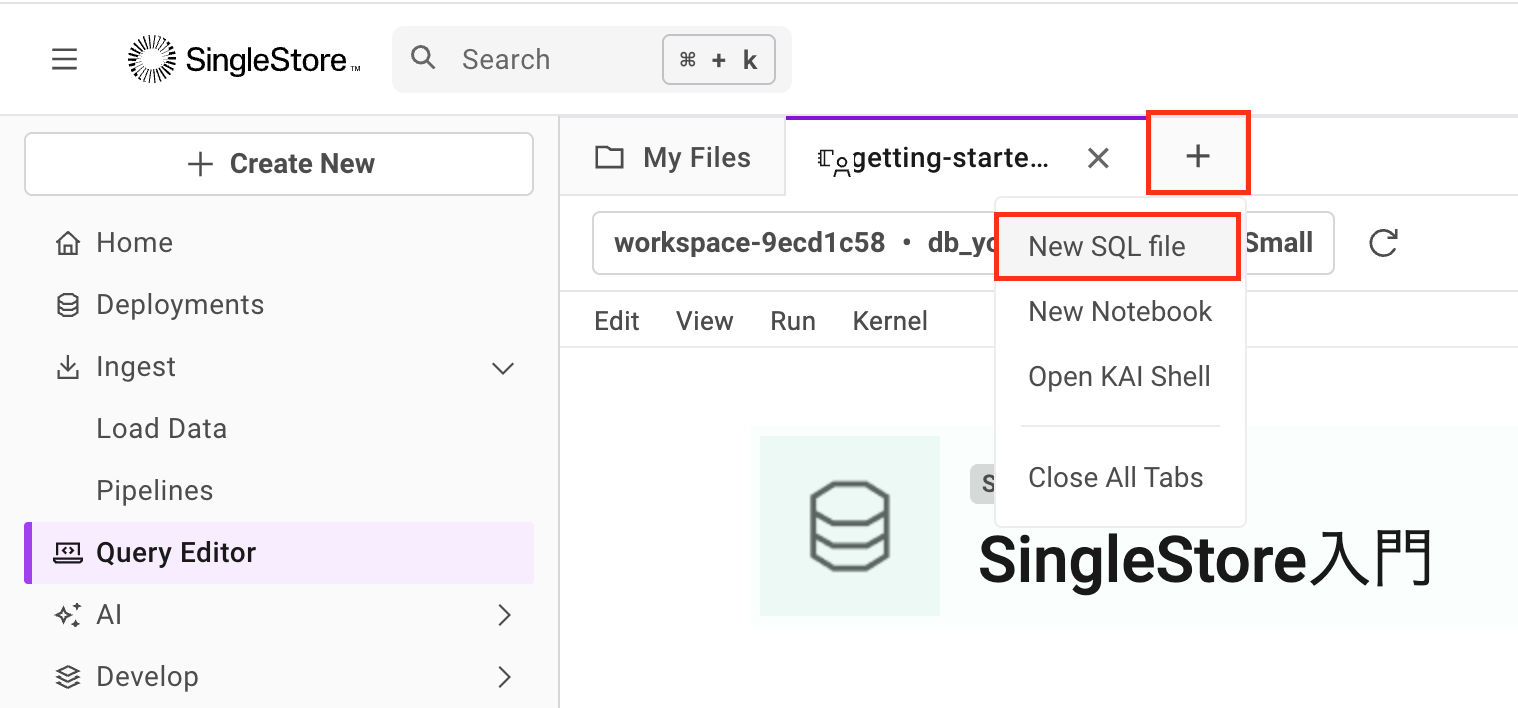

開いたSQL Editorに、先ほどコピーしたSQLを貼り付けます。
    
先頭の<b>%%sql</b>を削除します。

画面右上の<b>Visual Explain</b>をクリックして、<b>Profile</b>を選択すると、Visual Explainが表示されます。

<img src=attachment:98a8a536-9d6f-4503-bdc6-7079aea92346.png width=50%>
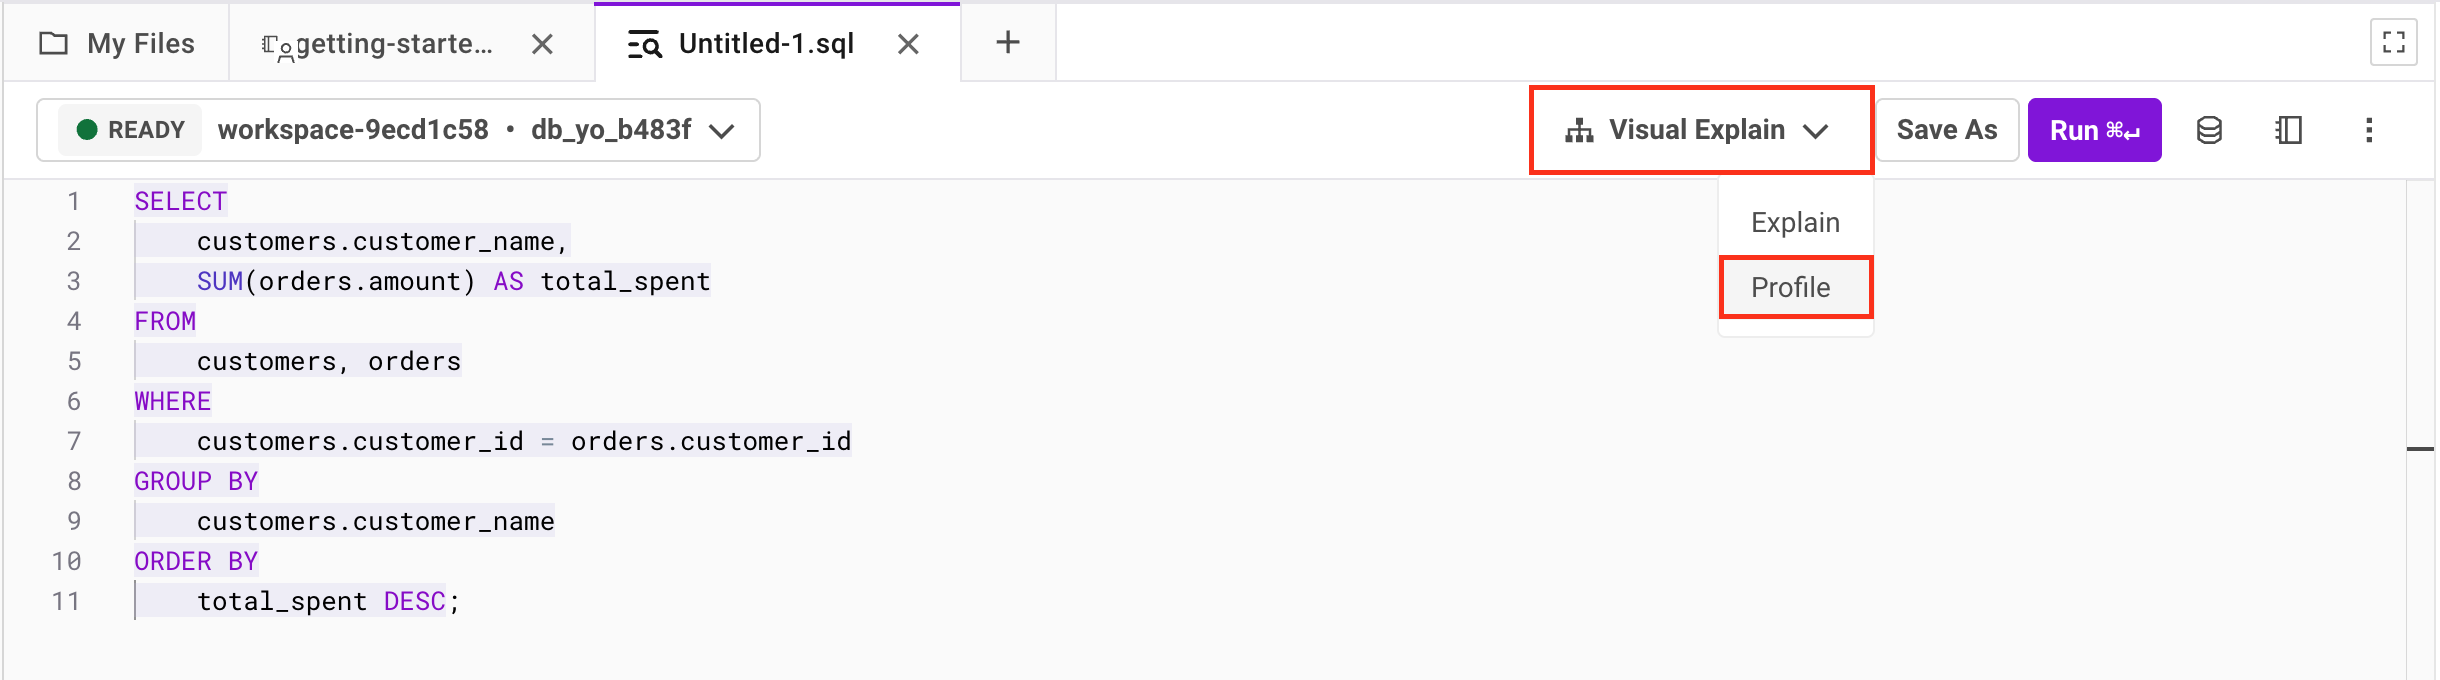

Visual Explainの表示が小さいときはズームインで拡大して、詳細を確認しましょう。

今回はデータ量が極端に少ないので特にボトルネックはありませんが、実際の運用でパフォーマンス問題が発生した場合は、同様の手順で分析できることを覚えておいてください。

# マルチモデルのデータ操作

## ベクトルの追加

### 注文テーブルに3次元ベクトルを追加する

In [37]:
%%sql
ALTER TABLE orders ADD COLUMN dimensions VECTOR(3);

5 rows affected.

++
||
++
++

### ベクトルデータを追加する

#### 3つの次元は、長さ（L）、幅（W）、高さ（H）をcm単位で表します。

In [38]:
%%sql
UPDATE orders SET dimensions = '[8.5, 5.5, 1.0]' WHERE order_id = 101;
UPDATE orders SET dimensions = '[0.5, 0.5, 14.0]' WHERE order_id = 102;
UPDATE orders SET dimensions = '[21.0, 29.7, 0.5]' WHERE order_id = 103;
UPDATE orders SET dimensions = '[32.0, 22.0, 2.0]' WHERE order_id = 104;
UPDATE orders SET dimensions = '[24.0, 16.0, 0.7]' WHERE order_id = 105;

1 rows affected.

1 rows affected.

1 rows affected.

1 rows affected.

1 rows affected.

++
||
++
++

### ベクトルを表示する

In [39]:
%%sql
SET vector_type_project_format = JSON;

SELECT
    *
FROM
    orders;

5 rows affected.

order_id,customer_id,amount,product,dimensions
101,1,150.00,Book,[8.5 5.5 1. ]
103,3,50.00,Notebook,[21. 29.7 0.5]
102,2,200.00,Pen,[ 0.5 0.5 14. ]
104,1,300.00,Laptop,[32. 22. 2.]
105,4,250.00,Tablet,[24. 16. 0.7]


### ドット積である<*>を使用してスコア順に並び替える

ドット積は、2 つのベクトルを乗算して 1 つの数値 (スカラー) を取得する方法です。

簡単に言えば、ドット積は、2 セットの数値を 1 つの値に結合する方法を提供し、その値はベクトルがどの程度同じ方向を指しているかを反映します。

In [40]:
%%sql
SET vector_type_project_format = JSON;

SELECT
    *,
    ROUND((dimensions <*> '[32.0, 22.0, 2.0]'), 2) AS score
--  ROUND(DOT_PRODUCT(dimensions, '[32.0, 22.0, 2.0]'), 2) AS score
FROM
    orders
ORDER BY
    score DESC;

5 rows affected.

order_id,customer_id,amount,product,dimensions,score
104,1,300.00,Laptop,[32. 22. 2.],1512.0
103,3,50.00,Notebook,[21. 29.7 0.5],1326.4
105,4,250.00,Tablet,[24. 16. 0.7],1121.4
101,1,150.00,Book,[8.5 5.5 1. ],395.0
102,2,200.00,Pen,[ 0.5 0.5 14. ],55.0


### ユークリッド距離である<->を使用してスコア順に並び替える

ユークリッド距離は、空間内で 2 点がどれだけ離れているかを測定する方法です。

簡単に言えば、ユークリッド距離は、地図上の 2 点間の距離を定規で測定するのと同じように、1 点間の距離を直線で測定します。

In [41]:
%%sql
SET vector_type_project_format = JSON;

SELECT
    *,
    ROUND((dimensions <-> '[32.0, 22.0, 2.0]'), 2) AS score
--  ROUND(EUCLIDEAN_DISTANCE(dimensions, '[32.0, 22.0, 2.0]'), 2) AS score
FROM
    orders
ORDER BY
    score ASC;

5 rows affected.

order_id,customer_id,amount,product,dimensions,score
104,1,300.00,Laptop,[32. 22. 2.],0.0
105,4,250.00,Tablet,[24. 16. 0.7],10.08
103,3,50.00,Notebook,[21. 29.7 0.5],13.51
101,1,150.00,Book,[8.5 5.5 1. ],28.73
102,2,200.00,Pen,[ 0.5 0.5 14. ],39.98


## 全文の追加

### 注文テーブルに説明列を追加する

In [42]:
%%sql
ALTER TABLE orders ADD COLUMN description VARCHAR(255);

5 rows affected.

++
||
++
++

### 注文テーブルを説明付きに更新する

In [44]:
%%sql
UPDATE orders
SET description = CASE
    WHEN product = "Book" THEN "A high-quality book that offers insightful content and engaging narratives."
    WHEN product = "Pen" THEN "A smooth-writing pen designed for comfort and precision."
    WHEN product = "Notebook" THEN "A versatile notebook perfect for notes, sketches, and ideas."
    WHEN product = "Laptop" THEN "A powerful laptop with high performance and sleek design for all your computing needs."
    WHEN product = "Tablet" THEN "A compact tablet with a vibrant display and versatile functionality."
    ELSE "A product with excellent features and quality."
END;

++
||
++
++

### 説明を表示する

In [45]:
%%sql
SELECT
    *
FROM
    orders;

5 rows affected.

order_id,customer_id,amount,product,dimensions,description
101,1,150.00,Book,[8.5 5.5 1. ],A high-quality book that offers insightful content and engaging narratives.
103,3,50.00,Notebook,[21. 29.7 0.5],"A versatile notebook perfect for notes, sketches, and ideas."
102,2,200.00,Pen,[ 0.5 0.5 14. ],A smooth-writing pen designed for comfort and precision.
104,1,300.00,Laptop,[32. 22. 2.],A powerful laptop with high performance and sleek design for all your computing needs.
105,4,250.00,Tablet,[24. 16. 0.7],A compact tablet with a vibrant display and versatile functionality.


### 注文テーブルに全文インデックスを追加する

In [46]:
%%sql
ALTER TABLE orders ADD FULLTEXT USING VERSION 2 orders_ft_index (product, description);
OPTIMIZE TABLE orders FLUSH;

Table,Op,Msg_type,Msg_text


### 説明部分で「vibrant」に一致するものを検索

In [47]:
%%sql
SELECT
    *
FROM
    orders
WHERE
    MATCH (TABLE orders) AGAINST ("description:vibrant");

1 rows affected.

order_id,customer_id,amount,product,dimensions,description
105,4,250.00,Tablet,[24. 16. 0.7],A compact tablet with a vibrant display and versatile functionality.


### 柔軟性を示すためにさまざまな演算子を使用する

#### + (必須)、* (複数のワイルドカード)、? (単一のワイルドカード)

In [49]:
%%sql
SELECT
    product, description
FROM
    orders
WHERE
    MATCH (TABLE orders) AGAINST ("product:(+oo?) OR description:versa*");

2 rows affected.

product,description
Notebook,"A versatile notebook perfect for notes, sketches, and ideas."
Tablet,A compact tablet with a vibrant display and versatile functionality.


## JSONの追加

### 注文テーブルにJSON列を追加する

In [50]:
%%sql
ALTER TABLE orders ADD COLUMN additional_details JSON NOT NULL;

5 rows affected.

++
||
++
++

### JSON 形式で追加の詳細を記載して注文テーブルを更新します

In [51]:
%%sql
UPDATE orders
SET additional_details = CASE
    WHEN order_id = 101 THEN '{
        "invoice_number": "INV1001",
        "order_status": "Delivered",
        "shipping_address": {
            "street": "456 Elm St",
            "city": "Toronto",
            "state": "ON",
        "postal_code": "M5A 1A1",
        "country": "Canada"
        },
        "payment_method": "Credit Card",
        "discounts_applied": [{
            "discount_code": "WELCOME10",
            "amount": 10.00
        }],
        "order_date": "2024-07-01",
        "estimated_delivery_date": "2024-07-05",
        "tracking_number": "TRACK1001",
        "customer_notes": "Leave at the front desk."
    }'
    WHEN order_id = 102 THEN '{
        "invoice_number": "INV1002",
        "order_status": "Pending",
        "shipping_address": {
            "street": "789 Oak St",
            "city": "Vancouver",
            "state": "BC",
            "postal_code": "V5K 1A1",
            "country": "Canada"
        },
        "payment_method": "PayPal",
        "discounts_applied": [{
            "discount_code": "SPRING20",
            "amount": 20.00
        }],
        "order_date": "2024-07-02",
        "estimated_delivery_date": "2024-07-06",
        "tracking_number": "TRACK1002",
        "customer_notes": "Contact me before delivery."
    }'
    WHEN order_id = 103 THEN '{
        "invoice_number": "INV1003",
        "order_status": "Shipped",
        "shipping_address": {
            "street": "321 Pine St",
            "city": "Montreal",
            "state": "QC",
            "postal_code": "H2X 1Y4",
            "country": "Canada"
        },
        "payment_method": "Credit Card",
        "discounts_applied": [{
            "discount_code": "SAVE15",
            "amount": 15.00
        }],
        "order_date": "2024-07-03",
        "estimated_delivery_date": "2024-07-07",
        "tracking_number": "TRACK1003",
        "customer_notes": "Deliver after 5 PM."
    }'
    WHEN order_id = 104 THEN '{
        "invoice_number": "INV1004",
        "order_status": "Shipped",
        "shipping_address": {
            "street": "654 Maple St",
            "city": "Calgary",
            "state": "AB",
            "postal_code": "T2P 1N4",
            "country": "Canada"
        },
        "payment_method": "Credit Card",
        "discounts_applied": [{
            "discount_code": "NEWYEAR25",
            "amount": 25.00
        }],
        "order_date": "2024-07-01",
        "estimated_delivery_date": "2024-07-08",
        "tracking_number": "TRACK1004",
        "customer_notes": "Leave package at the back door."
    }'
    WHEN order_id = 105 THEN '{
        "invoice_number": "INV1005",
        "order_status": "Delivered",
        "shipping_address": {
            "street": "987 Birch St",
            "city": "Ottawa",
            "state": "ON",
            "postal_code": "K1A 0A1",
            "country": "Canada"
        },
        "payment_method": "PayPal",
        "discounts_applied": [{
            "discount_code": "HOLIDAY30",
            "amount": 30.00
        }],
        "order_date": "2024-07-03",
        "estimated_delivery_date": "2024-07-09",
        "tracking_number": "TRACK1005",
        "customer_notes": "Please ring the doorbell."
    }'
    ELSE '{}'
END;

5 rows affected.

++
||
++
++

### 特定のJSONフィールドを抽出する

In [52]:
%%sql
SELECT
    order_id,
    additional_details::invoice_number AS invoice_number,
    additional_details::order_status AS order_status
FROM
    orders
ORDER BY
    order_id;

5 rows affected.

order_id,invoice_number,order_status
101,INV1001,Delivered
102,INV1002,Pending
103,INV1003,Shipped
104,INV1004,Shipped
105,INV1005,Delivered


### 「配達済み」の注文を検索する

In [53]:
%%sql
SELECT
    order_id,
    additional_details::invoice_number AS invoice_number
FROM
    orders
WHERE
    additional_details::order_status = '"Delivered"'
ORDER BY
    order_id;

2 rows affected.

order_id,invoice_number
101,INV1001
105,INV1005


### JSONフィールドに基づいてデータを集計する

In [54]:
%%sql
SELECT
    additional_details::order_status AS order_status,
    COUNT(*) AS order_count
FROM
    orders
GROUP BY
    order_status;

3 rows affected.

order_status,order_count
Shipped,2
Delivered,2
Pending,1


## 地理空間情報の追加

### 顧客テーブルにさらに2人の顧客を挿入する

In [55]:
%%sql
INSERT INTO customers (customer_id, customer_name, country) VALUES
(6, "Emily Davis", "Canada"),
(7, "Michael Johnson", "Canada");

2 rows affected.

++
||
++
++

### 地理空間データ用の近隣テーブルを作成する

In [56]:
%%sql
DROP TABLE IF EXISTS neighborhoods;

CREATE TABLE IF NOT EXISTS neighborhoods /* Creating table for sample data. */(
    id INT UNSIGNED NOT NULL,
    name VARCHAR(64) NOT NULL,
    population INT UNSIGNED NOT NULL,
    shape TEXT NOT NULL,
    centroid GEOGRAPHYPOINT NOT NULL,
    sort key (name),
    shard key (id)
);

++
||
++
++

### 近隣テーブルに都市データを追加する

In [57]:
%%sql
INSERT INTO neighborhoods (id, name, population, shape, centroid) VALUES
(1, "Toronto", 2794356,
    "POLYGON((-79.6393 43.6777, -79.1152 43.6777, -79.1152 43.8554, -79.6393 43.8554, -79.6393 43.6777))",
    "POINT(-79.3832 43.6532)"
),
(2, "Vancouver", 662248,
    "POLYGON((-123.2247 49.1985, -123.0234 49.1985, -123.0234 49.3169, -123.2247 49.3169, -123.2247 49.1985))",
    "POINT(-123.1216 49.2827)"
),
(3, "Montreal", 1762949,
    "POLYGON((-73.9354 45.3991, -73.4757 45.3991, -73.4757 45.7044, -73.9354 45.7044, -73.9354 45.3991))",
    "POINT(-73.5673 45.5017)"
),
(4, "Calgary", 1306784,
    "POLYGON((-114.3160 50.8420, -113.8599 50.8420, -113.8599 51.2124, -114.3160 51.2124, -114.3160 50.8420))",
    "POINT(-114.0719 51.0447)"
),
(5, "Ottawa", 1017449,
    "POLYGON((-75.9274 45.2502, -75.3537 45.2502, -75.3537 45.5489, -75.9274 45.5489, -75.9274 45.2502))",
    "POINT(-75.6972 45.4215)"
);

5 rows affected.

++
||
++
++

### 顧客テーブルに地理空間列を追加する

In [58]:
%%sql
ALTER TABLE customers ADD COLUMN location GEOGRAPHYPOINT;

7 rows affected.

++
||
++
++

### 位置データを使用して顧客テーブルを更新する

In [59]:
%%sql
UPDATE customers SET location = "POINT(-79.3832 43.6532)" WHERE customer_id = 1;
UPDATE customers SET location = "POINT(-123.1216 49.2827)" WHERE customer_id = 2;
UPDATE customers SET location = "POINT(-73.5673 45.5017)" WHERE customer_id = 3;
UPDATE customers SET location = "POINT(-114.0719 51.0447)" WHERE customer_id = 4;
UPDATE customers SET location = "POINT(-75.6972 45.4215)" WHERE customer_id = 5;
UPDATE customers SET location = "POINT(-79.3832 43.6532)" WHERE customer_id = 6;
UPDATE customers SET location = "POINT(-123.1216 49.2827)" WHERE customer_id = 7;

1 rows affected.

1 rows affected.

1 rows affected.

1 rows affected.

1 rows affected.

1 rows affected.

1 rows affected.

++
||
++
++

### 近隣テーブルをそれ自体に結合し、近隣間の距離を測定します

In [60]:
%%sql
SELECT
    b.name AS town,
    ROUND(GEOGRAPHY_DISTANCE(a.centroid, b.centroid), 0) AS distance_from_center,
    ROUND(GEOGRAPHY_DISTANCE(a.shape, b.shape), 0) AS distance_from_border
FROM
    neighborhoods a, neighborhoods b
WHERE
    a.name = "Vancouver"
ORDER BY
    2;

5 rows affected.

town,distance_from_center,distance_from_border
Vancouver,0.0,0.0
Calgary,672854.0,643265.0
Toronto,3357100.0,3321254.0
Ottawa,3537063.0,3507163.0
Montreal,3684327.0,3641142.0


### 自分の居場所を確認する

In [61]:
%%sql
SELECT
    name
FROM
    neighborhoods
WHERE
    GEOGRAPHY_INTERSECTS("POINT(-79.3770 43.7500)", shape);

1 rows affected.

name
Toronto


### 「バンクーバー」内の顧客を探す

In [62]:
%%sql
SELECT
    c.customer_id, c.customer_name
FROM
    customers c, neighborhoods n
WHERE
    n.name = "Vancouver" AND GEOGRAPHY_CONTAINS(n.shape, c.location);

2 rows affected.

customer_id,customer_name
7,Michael Johnson
2,Jane Smith


## 時系列の追加

### 日ごとに注文数をカウントする

In [63]:
%%sql
SELECT
    DATE_FORMAT(STR_TO_DATE(additional_details::order_date, '"%Y-%m-%d"'), '%Y-%m-%d') AS order_date,
    COUNT(*) AS order_count
FROM
    orders
GROUP BY
    order_date
ORDER BY
    order_date;

3 rows affected.

order_date,order_count
2024-07-01,2
2024-07-02,1
2024-07-03,2


### 月別の注文金額の合計

In [64]:
%%sql
SELECT
    DATE_FORMAT(STR_TO_DATE(additional_details::order_date, '"%Y-%m-%d"'), '%Y-%m') AS order_month,
    SUM(amount) AS total_amount
FROM
    orders
GROUP BY
    order_month
ORDER BY
    order_month;

1 rows affected.

order_month,total_amount
2024-07,950.00


### 顧客別の注文数の推移

In [65]:
%%sql
SELECT
    customer_id,
    DATE_FORMAT(STR_TO_DATE(additional_details::order_date, '"%Y-%m-%d"'), '%Y-%m-%d') AS order_date,
    COUNT(*) AS order_count
FROM
    orders
GROUP BY
    customer_id, order_date
ORDER BY
    customer_id, order_date;

4 rows affected.

customer_id,order_date,order_count
1,2024-07-01,2
2,2024-07-02,1
3,2024-07-03,1
4,2024-07-03,1


## （オプション）地図の作成

### 地理空間都市データから地図を作成する

In [66]:
!pip install folium shapely --quiet

In [67]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

### 近隣テーブルから都市データを取得する

In [68]:
import pandas as pd

query = """
    SELECT
        id,
        name,
        population,
        shape :> TEXT AS polygon,
        centroid :> TEXT AS point
    FROM
        neighborhoods
"""

df = pd.read_sql(
    query,
    db_connection
)

### データをPythonの地理空間形式に変換する

In [69]:
from shapely import wkt

df["polygon"] = df["polygon"].apply(wkt.loads)
df["point"] = df["point"].apply(wkt.loads)

### 地図上に都市をプロットする

In [70]:
import folium

m = folium.Map(
    location = [56.1304, -106.3468],
    zoom_start = 4
)

for idx, row in df.iterrows():
    folium.Polygon(
        locations = [(point[1], point[0]) for point in row["polygon"].exterior.coords],
        color = "blue",
        weight = 2,
        fill = True,
        fill_color = "blue",
        fill_opacity = 0.1
    ).add_to(m)

    folium.Marker(
        location = (row["point"].y, row["point"].x),
        popup = row["name"]
    ).add_to(m)

html_content = m._repr_html_()

### マップをステージに保存する

下記SQL内の<b>\<workspace_name\></b>を自身のワークスペース名（例：workspace-xxxxxx)に置き換えて実行します。自身のワークスペース名はNotebook上部のドロップダウンリストに表示されています。

In [71]:
# Pythonでローカルファイルを作成
with open('map.html', 'w') as f:
    f.write(html_content)

# Fusion SQLでStageにアップロード
%sql UPLOAD FILE TO STAGE 'map.html' IN '<workspace_name>' FROM 'map.html' OVERWRITE

++
||
++
++

左側メニューの<b>Deployments</b>から<b>Stage</b>タブに移動し、`map.html`の右側の3点リーダーをクリックして<b>Download</b>を選択してローカルPCにダウンロードします。

<img src=attachment:26e1767b-a123-4e4e-8206-3773900a1535.png>
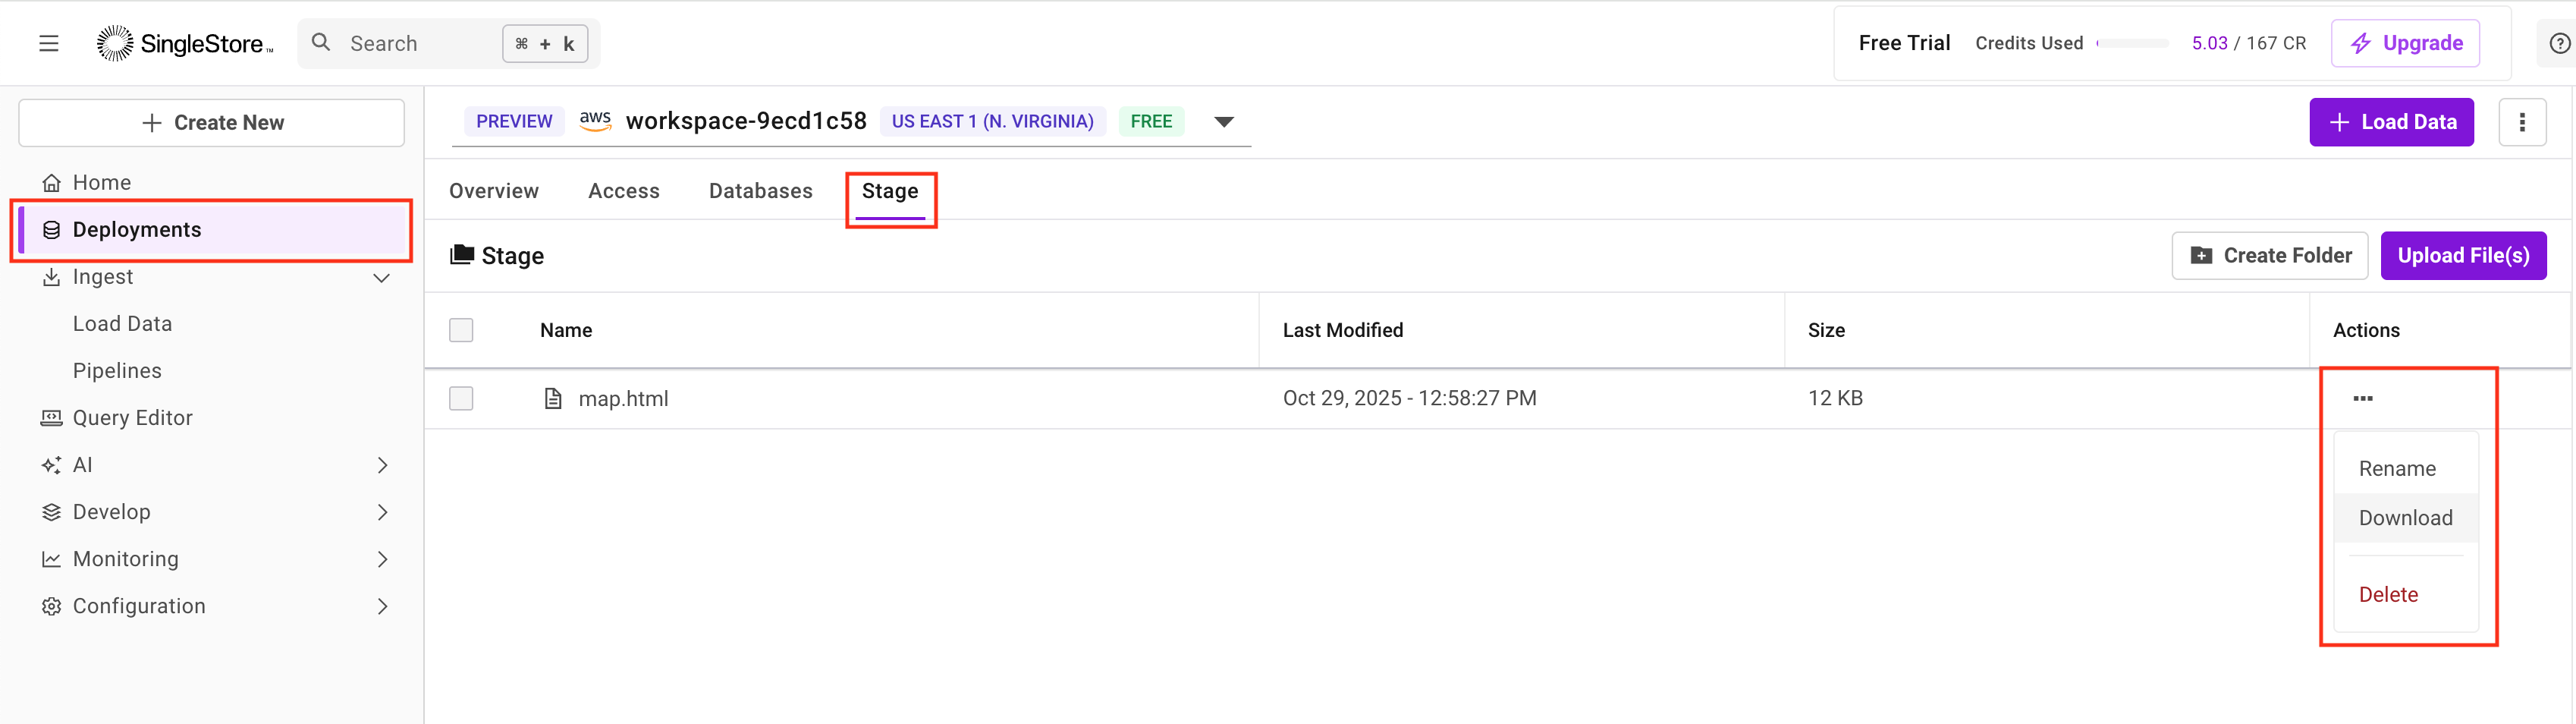

ダウンロードした`map.html`をブラウザで開くとマップが表示されます。

# Stageの活用

## StageへのSQL結果のエクスポート

Stageは、 SingleStore Heliosデータベースへの取り込み用にローカルファイルを整理・管理するのに役立つストレージサービスです。各ワークスペースグループにはStageがあり、そこでフォルダを作成したりファイルをアップロードしたりできます。

次のように、SQL結果をStageにCSVファイルとしてエクスポートしてみましょう。

In [77]:
%%sql
%%sql
SELECT * FROM customers ORDER BY 1 INTO STAGE 'customers.csv'
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\n';

7 rows affected.

++
||
++
++

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p>各リーフ ノードから複数のファイルを取得することを避けるには、<b>ORDER BY 1</b> 句を使用します。</p>
    </div>
</div>

左側メニューの<b>Deployments</b>から<b>Stage</b>タブに移動し、CSVファイルが保存されていることを確認します。

## Stageからのデータ取り込み

エクスポートしたCSVファイルを、今度は別テーブルとしてSingleStore Pipelineを使って取り込んでみましょう。

### 新規テーブルの作成

新規で`customers2`テーブルを作成します。

In [83]:
%%sql
CREATE TABLE IF NOT EXISTS customers2 (
    customer_id INT PRIMARY KEY,
    customer_name VARCHAR(50),
    country VARCHAR(50),
    location GEOGRAPHYPOINT
);

++
||
++
++

### Pipelineの作成

In [84]:
%%sql
CREATE PIPELINE `customers2`
AS LOAD DATA STAGE 'customers.csv'
BATCH_INTERVAL 45000
DISABLE OUT_OF_ORDER OPTIMIZATION
DISABLE OFFSETS METADATA GC
SKIP DUPLICATE KEY ERRORS -- SKIP ALL ERRORS can be used to skip all errors that can be tracked through "Monitor the pipeline for errors"
INTO TABLE `customers2`
FIELDS TERMINATED BY ',' ENCLOSED BY '"' ESCAPED BY '\\' 
LINES TERMINATED BY '\n' STARTING BY '' 
FORMAT CSV
(
	`customers2`.`customer_id`,
	`customers2`.`customer_name`,
	`customers2`.`country`,
	`customers2`.`location`
);

++
||
++
++

### Pipelineの開始

In [85]:
%%sql
START PIPELINE `customers2`;

++
||
++
++

Pipelineにエラーがないかを確認します。タイトルの項目名だけが表示され、何もエラーが記録されていなければ問題ありません。

In [86]:
%%sql
SELECT * FROM information_schema.pipelines_errors
WHERE pipeline_name ='customers2';

DATABASE_NAME,PIPELINE_NAME,ERROR_UNIX_TIMESTAMP,ERROR_TYPE,ERROR_CODE,ERROR_MESSAGE,ERROR_KIND,STD_ERROR,LOAD_DATA_LINE,LOAD_DATA_LINE_NUMBER,BATCH_ID,ERROR_ID,BATCH_SOURCE_PARTITION_ID,BATCH_EARLIEST_OFFSET,BATCH_LATEST_OFFSET,HOST,PORT,PARTITION


データがテーブルにロードされていることを確認します。

In [87]:
%%sql
SELECT * FROM `customers2`
LIMIT 100;

7 rows affected.

customer_id,customer_name,country,location
3,Sam Brown,Canada,POINT(-73.56730000 45.50169997)
1,John Doe,Canada,POINT(-79.38320000 43.65319997)
6,Emily Davis,Canada,POINT(-79.38320000 43.65319997)
7,Michael Johnson,Canada,POINT(-123.12160001 49.28270002)
5,Mark Black,Canada,POINT(-75.69720001 45.42150002)
2,Jane Smith,Canada,POINT(-123.12160001 49.28270002)
4,Lisa White,Canada,POINT(-114.07189995 51.04470001)


<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p>今回はSingle Store Pipelineを使用してStageからデータを取り込みましたが、同様にS3やKafkaからもPipelineを使用してデータを取り込むことができます。</p>
    </div>
</div>

# Shard Keyとデータスキュー

このセクションでは、Shard Keyとデータスキュー（データの偏り）との関係を学びます。

`o_orderpriority`をShard Keyとしてテーブルを作成します。

In [5]:
%%sql
CREATE TABLE orders2 (
  o_orderkey bigint(11) NOT NULL,
  o_custkey int(11) NOT NULL,
  o_orderstatus char(1) CHARACTER SET utf8 COLLATE utf8_general_ci NOT NULL,
  o_totalprice decimal(15,2) NOT NULL,
  o_orderdate date NOT NULL,
  o_orderpriority char(15) CHARACTER SET utf8 COLLATE utf8_general_ci NOT NULL,
  o_clerk char(15) CHARACTER SET utf8 COLLATE utf8_general_ci NOT NULL,
  o_shippriority int(11) NOT NULL,
  o_comment varchar(79) CHARACTER SET utf8 COLLATE utf8_general_ci NOT NULL,
  SHARD KEY (o_orderpriority)
);

++
||
++
++

S3から上記テーブルにデータを取り込むためのPipelineを作成します。

In [6]:
%%sql
CREATE OR REPLACE PIPELINE tpch_100_orders
    AS LOAD DATA S3 'memsql-tpch-dataset/sf_100/orders/'
    config '{"region":"us-east-1"}'
    SKIP DUPLICATE KEY ERRORS
    INTO TABLE orders2
    FIELDS TERMINATED BY '|'
    LINES TERMINATED BY '|
';

++
||
++
++

Pipelineを開始します。

In [7]:
%%sql
START PIPELINE tpch_100_orders;

++
||
++
++

取り込まれたデータを確認します（データの取り込みには少し時間がかかります）。

In [9]:
%%sql
SELECT COUNT(*) FROM orders2;

1 rows affected.

COUNT(*)
2400000


In [11]:
%%sql
SELECT * FROM orders2 LIMIT 5;

5 rows affected.

o_orderkey,o_custkey,o_orderstatus,o_totalprice,o_orderdate,o_orderpriority,o_clerk,o_shippriority,o_comment
29970887,6861998,O,19049.28,1997-11-24,3-MEDIUM,Clerk#000092464,0,ajole against the fluffily final packages. even deposits bo
8038049,1146878,F,280747.20,1994-01-23,3-MEDIUM,Clerk#000083083,0,regular ideas wake around the special notornis. theodolites play f
8038050,572677,O,226899.55,1996-05-12,3-MEDIUM,Clerk#000071711,0,to the final dependencies. ironic theodolites nag iro
29971040,2331040,F,16559.67,1993-05-23,3-MEDIUM,Clerk#000082067,0,endencies? idly ironic packages nag furiously
29971012,11179075,F,202820.67,1995-02-26,3-MEDIUM,Clerk#000010417,0,integrate blithely ironic pinto beans. requests alongside o


データスキューの状況をパーティションの行数で確認します。

In [12]:
%%sql
SELECT
    DATABASE_NAME,
    TABLE_NAME,
    ORDINAL AS PARTITION_ID,
    ROWS,
    MEMORY_USE
FROM INFORMATION_SCHEMA.TABLE_STATISTICS
WHERE TABLE_NAME = 'orders2';

4 rows affected.

DATABASE_NAME,TABLE_NAME,PARTITION_ID,ROWS,MEMORY_USE
db_yo_b483f,orders2,0,14396420,0
db_yo_b483f,orders2,0,14396420,0
db_yo_b483f,orders2,1,9603580,0
db_yo_b483f,orders2,1,9603580,0


かなりのデータスキューが発生していたので、今度は`o_orderkey`をShard Keyとして別のテーブルを作成してみます。

In [14]:
%%sql
CREATE TABLE orders3 (
  o_orderkey bigint(11) NOT NULL,
  o_custkey int(11) NOT NULL,
  o_orderstatus char(1) CHARACTER SET utf8 COLLATE utf8_general_ci NOT NULL,
  o_totalprice decimal(15,2) NOT NULL,
  o_orderdate date NOT NULL,
  o_orderpriority char(15) CHARACTER SET utf8 COLLATE utf8_general_ci NOT NULL,
  o_clerk char(15) CHARACTER SET utf8 COLLATE utf8_general_ci NOT NULL,
  o_shippriority int(11) NOT NULL,
  o_comment varchar(79) CHARACTER SET utf8 COLLATE utf8_general_ci NOT NULL,
  SHARD KEY (o_orderkey)
);

RuntimeError: (singlestoredb.exceptions.OperationalError) 1050: Forwarding Error (node-ca6059f6-d80a-4b49-8c85-eb3223ecfd67-master-0.svc-ca6059f6-d80a-4b49-8c85-eb3223ecfd67:3306): Table 'orders3' already exists
[SQL: CREATE TABLE orders3 (
  o_orderkey bigint(11) NOT NULL,
  o_custkey int(11) NOT NULL,
  o_orderstatus char(1) CHARACTER SET utf8 COLLATE utf8_general_ci NOT NULL,
  o_totalprice decimal(15,2) NOT NULL,
  o_orderdate date NOT NULL,
  o_orderpriority char(15) CHARACTER SET utf8 COLLATE utf8_general_ci NOT NULL,
  o_clerk char(15) CHARACTER SET utf8 COLLATE utf8_general_ci NOT NULL,
  o_shippriority int(11) NOT NULL,
  o_comment varchar(79) CHARACTER SET utf8 COLLATE utf8_general_ci NOT NULL,
  SHARD KEY (o_orderkey)
);]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
If you need help solving this issue, send us a message: https://ploomber.io/community


`orders2`テーブルから`orders3`テーブルにデータをコピーします（データ量を絞るため10万行に制限しています）

In [15]:
%%sql
INSERT INTO orders3 SELECT * FROM orders2 LIMIT 100000;

100000 rows affected.

++
||
++
++

もう一度データスキューの状況をパーティションの行数で確認すると、偏りがほとんどないことがわかります。

In [16]:
%%sql
SELECT
    DATABASE_NAME,
    TABLE_NAME,
    ORDINAL AS PARTITION_ID,
    ROWS,
    MEMORY_USE
FROM INFORMATION_SCHEMA.TABLE_STATISTICS
WHERE TABLE_NAME = 'orders3';

4 rows affected.

DATABASE_NAME,TABLE_NAME,PARTITION_ID,ROWS,MEMORY_USE
db_yo_b483f,orders3,0,50013,13244448
db_yo_b483f,orders3,0,50013,13244448
db_yo_b483f,orders3,1,49987,13240696
db_yo_b483f,orders3,1,49987,13240696


データスキューを発生させないためには、テーブル作成時に適切なShard Keyを選択することが重要になります。

# 環境の削除

## Pipelineの停止

In [17]:
%%sql
STOP PIPELINE `customers2`;

RuntimeError: (singlestoredb.exceptions.OperationalError) 1944: Forwarding Error (node-ca6059f6-d80a-4b49-8c85-eb3223ecfd67-master-0.svc-ca6059f6-d80a-4b49-8c85-eb3223ecfd67:3306): Pipeline `customers2` does not exist
[SQL: STOP PIPELINE `customers2`;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
If you need help solving this issue, send us a message: https://ploomber.io/community


In [18]:
%%sql
STOP PIPELINE `tpch_100_orders`;

++
||
++
++

## Pipelineの削除

In [19]:
%%sql
DROP PIPELINE `customers2`;

RuntimeError: (singlestoredb.exceptions.OperationalError) 1944: Forwarding Error (node-ca6059f6-d80a-4b49-8c85-eb3223ecfd67-master-0.svc-ca6059f6-d80a-4b49-8c85-eb3223ecfd67:3306): Pipeline `customers2` does not exist
[SQL: DROP PIPELINE `customers2`;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
If you need help solving this issue, send us a message: https://ploomber.io/community


In [20]:
%%sql
DROP PIPELINE `tpch_100_orders`;

++
||
++
++

## テーブルの削除

In [21]:
%%sql
DROP TABLE IF EXISTS customers;
DROP TABLE IF EXISTS customers2;
DROP TABLE IF EXISTS orders;
DROP TABLE IF EXISTS orders2;
DROP TABLE IF EXISTS orders3;
DROP TABLE IF EXISTS neighborhoods;

++
||
++
++

## Stage内に作成したファイルの削除

左側メニューの<b>Deployments</b>から<b>Stage</b>タブに移動し、`map.html`と`customers.csv`ファイルの右側の3点リーダーをクリックして<b>Delete</b>を選択して削除します。

## Shared Tier以外では今回作成したデータベースを削除

In [92]:
shared_tier_check = %sql SHOW VARIABLES LIKE "is_shared_tier"
if not shared_tier_check or shared_tier_check[0][1] == "OFF":
    %sql DROP DATABASE IF EXISTS multi_model;

1 rows affected.

# まとめ

このJupyterノートブックでは、SingleStoreの堅牢なマルチモデル機能を検証し、統合データベースプラットフォーム内で幅広いデータタイプを効率的に管理およびクエリする方法を示しました。

シンプルな「入門」ガイドから始まり、様々な標準SQLクエリを段階的に掘り下げ、機械学習用ベクター、非構造化データの全文検索、階層型データ用のJSON、位置情報クエリ用の地理空間データ、時系列分析用の時系列データなど、より高度なデータモデルへと探求を広げました。

また、StageへのSQL結果の出力と、SingleStore Pipelineを使用してStageからデータを取り込む方法を確認しました。

これらの実践的な例を通して、ユーザーはSingleStoreの汎用性と強力な機能を理解し、多様なアプリケーションでマルチモデル機能を効果的に活用するスキルを習得できます。

# 時間が余った方は・・・

下記のSingleStore Spacesのサイトで、ぜひ他のNotebookも試してみてください（英語になります）。

https://www.singlestore.com/spaces/

左側のフィルタ欄の<b>Development Type</b>で<b>Shared-Tier</b>にチェックを入れると、無料のスターターワークスペースでも実行できるNotebookだけが表示されます。

<img src=attachment:d4f55c7d-3a26-41c1-bbe8-86456c6c16d3.png width=60%>

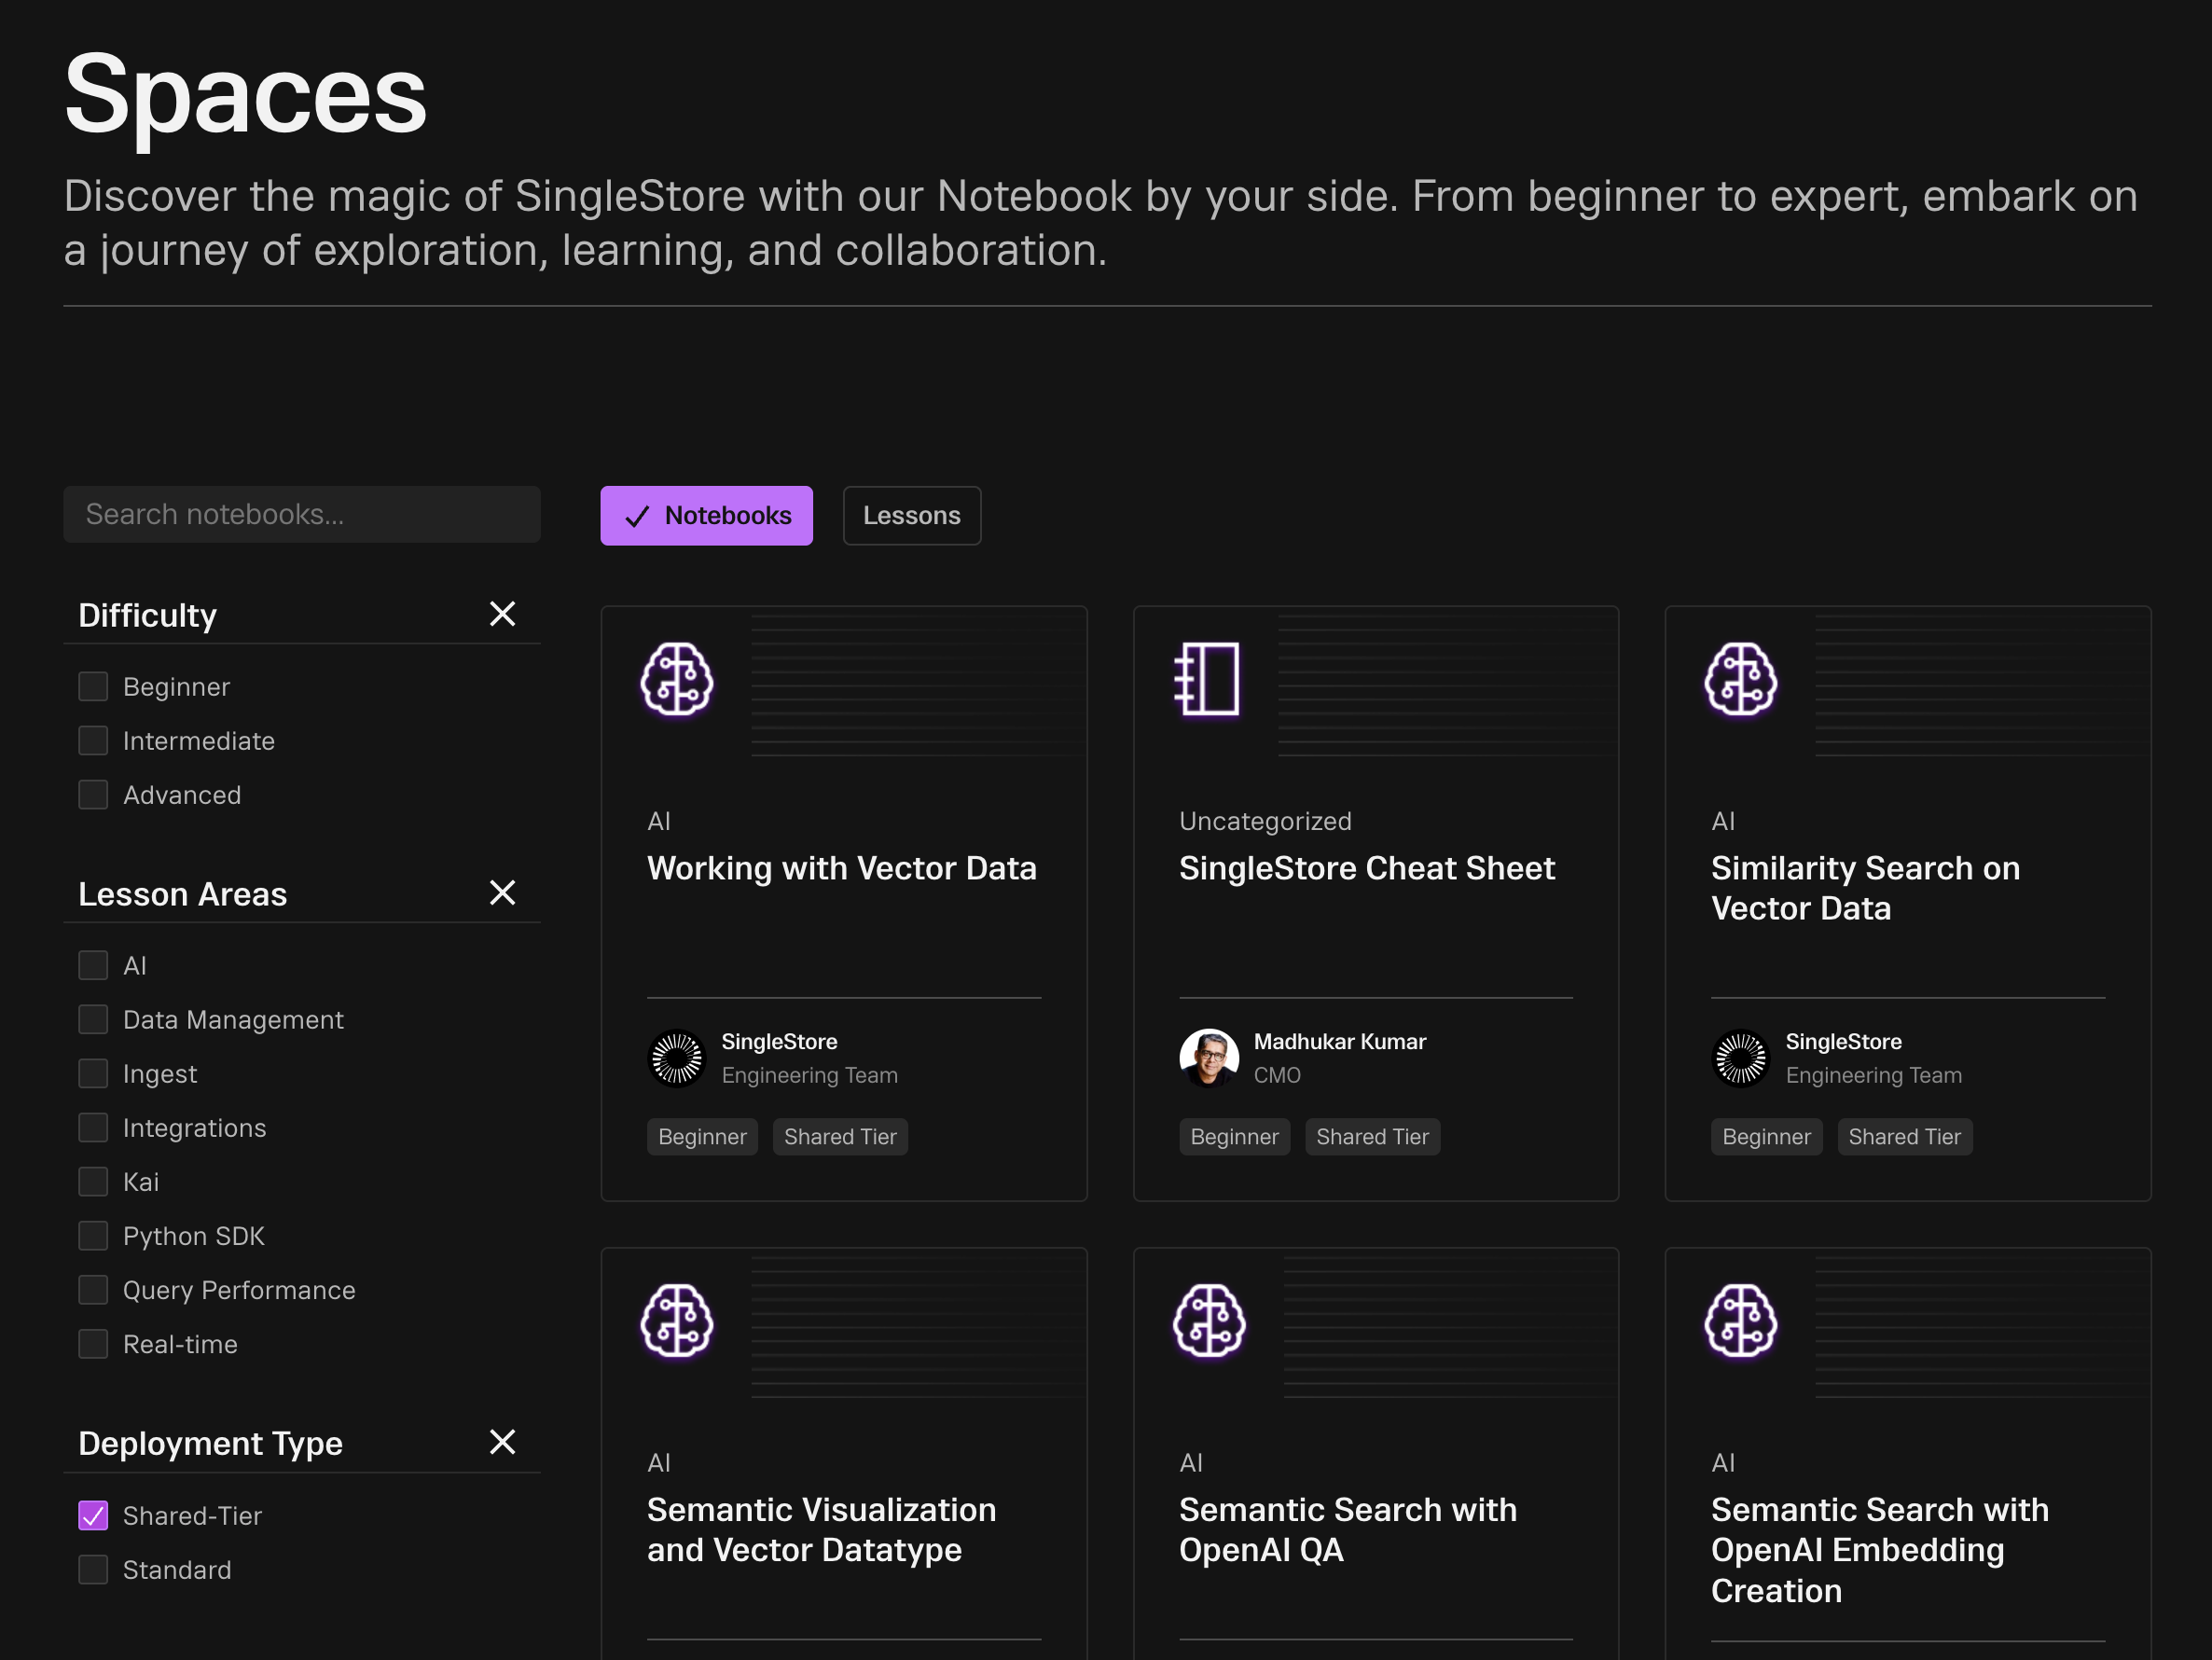

<div id="singlestore-footer" style="background-color: rgba(194, 193, 199, 0.25); height:2px; margin-bottom:10px"></div>
<div><img src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/singlestore-logo-grey.png" style="padding: 0px; margin: 0px; height: 24px"/></div>